In [1]:
import pandas as pd
import re
from scipy.stats import spearmanr, pearsonr

# Figure settings
import string
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='ticks',
    font='Arial', font_scale=1,
    rc={'figure.figsize':(4,4)})
sns.set_palette('pastel')

plt.rcParams["figure.figsize"] = (4,4)

%matplotlib inline

# Directories
ANALYSIS_DIR = '/home/sg/wrk/s/matlab/modcell-hpc-study/analysis'

In [7]:
def get_products(df):
    products = []
    for name in df.columns:
        if 'objective' in name:
            products.append(name.replace('(objective)',''))
    return products


# Obtain relevant info for a given case
def process_case(pid):

    apf = pd.read_csv(f'{ANALYSIS_DIR}/partitions/partition_{pid}_a/results/a5_b1.csv')
    bpf = pd.read_csv(f'{ANALYSIS_DIR}/partitions/partition_{pid}_b/results/a5_b1.csv')

    aprod = get_products(apf)
    bprod = get_products(bpf)

    # Load full solutions
    afpf = pd.read_csv(f'{ANALYSIS_DIR}/partitions/pf_partition_{pid}_a.csv')
    bfpf = pd.read_csv(f'{ANALYSIS_DIR}/partitions/pf_partition_{pid}_b.csv')

    # Only keep objectives that were recalculated:
    afpf = afpf.loc[:, ~afpf.columns.str.contains('objective_$')]
    bfpf = bfpf.loc[:, ~bfpf.columns.str.contains('objective_$')]

    ## Convert column names to original:
    def col_rename(name):
        # Names originally starting with numbers have an x inserted before,
        if 'objective' in name:
            prodid = re.search('(?:x|z)?(.*)_objective(_calc)?', name).group(1) #TODO: Is it x or z, or both (see safe_product_id method in matlab code)
            return f'{prodid}(objective)'
        else:
            return name

    afpf.rename(columns=col_rename, inplace=True)  
    bfpf.rename(columns=col_rename, inplace=True)
    
    # Compute unknown compatibility of each design
    compat_t = 0.5

    def find_compat(design_df, unknown_prod_id):
        odf = design_df[design_df.columns[design_df.columns.str.contains('(objective)')]]
        odf.columns = odf.columns.str.replace('\(objective\)','')
        cdf = odf.round(2) >= compat_t
        return cdf[unknown_prod_id].sum(axis=1)

    a_uc = find_compat(afpf,bprod)
    b_uc = find_compat(bfpf,aprod)
    
    # Compute known compatibility
    a_c = find_compat(afpf,aprod)
    b_c = find_compat(bfpf,bprod)
    
    # Package return:
    info = {}
    info['a_uc'] = a_uc
    info['b_uc'] = b_uc
    info['a_c'] = a_c
    info['b_c'] = b_c
    
    info['afpf'] = afpf
    info['bfpf'] = bfpf
    
    return info

infos = {case:process_case(case) for case in [1,2,3]}

/home/sg/.envs/modcell-analysis/lib/python3.8/site-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


# Analysis ideas

 The unknown compatibility of a design, is the number of tested unknown products towards which the design is compatible

- Plot the distribution of unknown compatibilities for each parittion
- Show the top designs with the most unknown compatibility
- Interrogate additional patterns such as representative products/ products that tend to enable compatibility
- Is known to unknown ratio for each design intersing?

#### Find unknown compatibility likelyhood:
If product x is compatible in design d, what are the chances that unknown product y is compatible with design d?
Take all compatible designs with product x  where product y is unknown and compute the ratio of total designs to the ones where y is compatible.

This might not be feasible for all products since the partitions are random

## Compatibility distributions

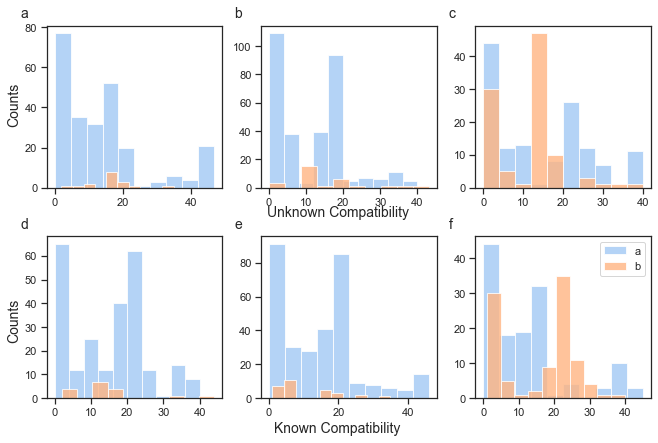

In [3]:
# In the top part do known compatibility distribution, in the bottom part unknown compatibility? 
# Do designs with high known compatibility tend to have lower known compatibility?

ncols=3
nrows=2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols,3*nrows))
ax = axs.flat

for i in [1,2,3]:  
    cax = ax[i-1]
    cax.hist(infos[i]['a_uc'], alpha=.8, label='a')
    cax.hist(infos[i]['b_uc'], alpha=.8, label='b')
    cax.grid(False)

    
for i in [1,2,3]:
    cax = ax[i+2]
    ax[i+2].hist(infos[i]['a_c'], alpha=.8, label='a')
    ax[i+2].hist(infos[i]['b_c'], alpha=.8, label='b')
    #cax.grid(axis='x')
    cax.grid(False)

plt.legend()

fig.text(0.5, .49, 'Unknown Compatibility', ha='center',size=14)
fig.text(0.5, -.01, 'Known Compatibility', ha='center',size=14)

fig.text(-.01, 0.75, 'Counts', va='center', rotation='vertical',size=14)
fig.text(-.01, 0.25, 'Counts', va='center', rotation='vertical',size=14)

for n, ax in enumerate(axs.flat):
    ax.text(-0.15, 1.05, string.ascii_lowercase[n], transform=ax.transAxes, 
            size=14)
    
plt.tight_layout()


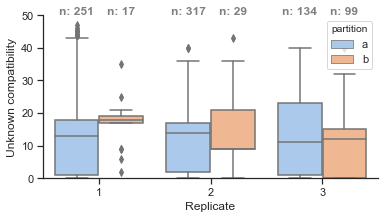

In [4]:


# Plot as a compact box plot
plt.figure(figsize=(6,3))
# Create nice dataframe for seaborn: partition | compatibility (choose one type) | replicate
acases = pd.DataFrame()
for rep in [1,2,3]:
    for part in ['a','b']:
        casedf = infos[rep][f'{part}_uc']
        casedf.name = 'compatibility'
        casedf = casedf.to_frame()
        casedf['partition'] = part
        casedf['replicate'] = str(rep)
        acases = acases.append(casedf)

acases['compatibility'] = pd.to_numeric(acases['compatibility'])

ax = sns.boxplot(x="replicate", y="compatibility", data=acases, hue="partition")

# Add number of observations
nobs =  acases.groupby(['partition','replicate']).apply(lambda x: 'n: {}'.format(len(x)))

for tick, label in enumerate(ax.get_xticklabels()):
    ax_replicate = label.get_text()

    for j, ax_partition in enumerate(ax.get_legend_handles_labels()[1]):
        x_offset = (j - 0.5) * 2/5
        med_val = 50 
        num = nobs[ax_partition, ax_replicate]

        ax.text(tick + x_offset, med_val + 0.1, num,
                horizontalalignment='center', size=12, color='gray', weight='semibold')


plt.yticks([0,10,20,30,40,50])
sns.despine()
plt.xlabel('Replicate')
plt.ylabel('Unknown compatibility')
plt.ylim(bottom=0)
plt.savefig('compat_distrb.svgz')

## Correlation between known and unkown compatibility

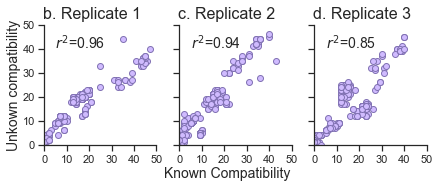

In [6]:
# In the top part do known compatibility distribution, in the bottom part unknown compatibility? 
# Do designs with high known compatibility tend to have lower known compatibility?
sns.set_style("ticks")
ncols=3
nrows=1
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6,2.5), sharey=True)
ax = axs.flat

plt.setp(axs, xticks=[0,10,20,30,40,50], yticks=[0,10,20,30,40,50])

pal = sns.color_palette('pastel')
pald = sns.color_palette('deep')
for i in [1,2,3]:  
    cax = ax[i-1]
    x = infos[i]['a_uc'].append(infos[i]['b_uc'])
    y = infos[i]['a_c'].append(infos[i]['b_c'])
    cax.scatter(x,y, color=pal[4], edgecolors=pald[4])
    cax.grid(False)
    cax.set_xlim(left=0, right=50)
    cax.set_ylim(bottom=0, top=50)
    ## lines
    sns.despine()
    
## save
    #cax.tick_params(axis='both' , direction='in',length=10, width=2, which='major')  
#for n, ax in enumerate(axs.flat):
    #ax.set(adjustable='box', aspect='equal')
    
#plt.legend()
fig.text(0.5, -.015, 'Known Compatibility', ha='center',size=14)
fig.text(-.01, 0.5, 'Unkown compatibility', va='center', rotation='vertical',size=14)

# Add correlation coefficients
for n, ax in enumerate(axs.flat):
    i = n+1
    x = infos[i]['a_uc'].append(infos[i]['b_uc'])
    y = infos[i]['a_c'].append(infos[i]['b_c'])
    (srho,p) = spearmanr(x,y)
    #(prho,p) = pearsonr(x,y)
    ax.text(.1, .8, '$r^2$={:.2f}'.format(srho), transform=ax.transAxes, 
            size=14)

# Add labels
for n, ax in enumerate(axs.flat):
    ax.text(-0.01, 1.05, '{}. Replicate {}'.format(string.ascii_lowercase[n+1],n+1), transform=ax.transAxes, 
            size=16)
    
plt.tight_layout()

plt.savefig('compat_correl.svgz')

## Top 3 designs with the most unkown compatibility for each case?

Estimate contribution of reaction deletions to unkown compatibility:

uc contribution of Ri = sum of uc in designs where Ri appears / total designs 


In [96]:
# Get list of possible deletions
def get_del(del_series):
    deletions = []
    for dels in del_series:
        deletions.extend(dels.split(', '))
    return set(deletions) 

uniqdel = set()
for i in [1,2,3]: 
    dela = get_del(infos[i]['afpf']['Deletion_id'])
    delb = get_del(infos[i]['bfpf']['Deletion_id'])
    uniqdel = uniqdel.union(dela).union(delb)


# Obtain contributions:
def obtain_contrib(rxn_id, deldf):
    contrib = 0
    for idx,row in deldf.iterrows():
        if rxn_id in row['Deletion_id'].split(', '):
            contrib = contrib + row['uc']
    return contrib/deldf.shape[0]


contrib = pd.DataFrame()
contrib['id'] = list(uniqdel)

for i in [1,2,3]:
    dfa = pd.concat([infos[i]['afpf']['Deletion_id'],infos[i]['a_uc']])
    auc = infos[i]['a_uc']
    auc.name = 'uc'
    dfa = pd.concat([infos[i]['afpf']['Deletion_id'],auc], axis=1)
    
    buc = infos[i]['b_uc']
    buc.name = 'uc'
    bfa = pd.concat([infos[i]['bfpf']['Deletion_id'],buc], axis=1)
    
    deldf = pd.concat([dfa,bfa])
    contrib[i] = contrib['id'].map(lambda x: obtain_contrib(x, deldf))

contrib['mean'] = contrib.mean(axis=1)
contrib = contrib.sort_values(by='mean', ascending=False)
contrib.head(10)

,id,1,2,3,mean
44,LDH_D,13.216418,10.546243,11.927039,11.896566
38,ALCD2x,11.470149,10.465318,11.824034,11.253167
172,PTAr,3.951493,4.832370,6.450644,5.078169
65,ACALD,4.496269,2.789017,2.939914,3.408400
118,THD2pp,4.667910,2.439306,2.193133,3.100117


In [115]:
# Add some useful info and write table out
# Utility functions
def write_table(name, dataframe, index=False):
    pd.set_option('display.max_colwidth', -1) # Avoid truncating strings
    with open(name, 'w') as tf:
        tf.write(dataframe.to_latex(index=index).replace('-->',r'$\rightarrow$').replace('<==>',r'$\leftrightarrow$'))

    pd.options.display.float_format = '{:.1f}'.format

rxn_info = pd.read_csv(f'{ANALYSIS_DIR}/native/rxns.tsv',delimiter='\t',index_col='id')

tout = contrib.set_index('id').join(rxn_info)
tout = tout.iloc[0:10,[4,0,1,2,3]]

#df = df[['mean', '0', '1', '2', '3']]
write_table('uc_contrib.tex', tout,index=True)

In [113]:
cd partitions/

/home/sg/wrk/s/matlab/modcell-hpc-study/analysis/partitions
